-------------------------------------------------------
- Wiley Winters
- MSDS 686 Deep Learning
- Week 7-8 Kaggle Project&nbsp;&mdash;&nbsp;Brain Tumor Classification
- 2025-MAR-09
--------------------------------------------------------

## Requirements

----------------------------------------------
### Required for 80%
Complete project on *kaggle.com* using the skills learned in the <u>Deep Learning</u> class.  The following are required:
- Show/plot sample images or data with labels
- Include at least on of the following
  - Convolution
  - Max Pooling
  - Batch Normalization
  - Dropout
  - LSTM
  - TF-IDf
- Use validation data
- Evaluate model on test data

-------------------------------------------
## Additional for another 20%
- Use data augmentation
- Use at least one of the following:
  - Kernels
  - Activation functions
  - Loss functions
  - Libraries
  - Methods
- Learning rate optimization
- Functional API model
- Transfer learning with or without trainable parameters
- Confusion matrix and / or ROC plots
- Plots of accuracy/loss vs epochs
- Show/plot sample incorrect prediction with labels and correct label

----------------------------------------------------------------
<a name='imports'></a>
## 1.0 <span style='color:blue'>|</span> Load Libraries and Packages

In [1]:
# General Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os, logging, random

# Data prep and model scoring
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

# TensorFlow likes to display a lot of debug information
# on my home system
# I will squash the messages
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
logging.getLogger('tensorFlow').setLevel(logging.FATAL)

# tensorflow and keras' API
import tensorflow as tf
from tensorflow import keras

# Model building
from tensorflow.keras import backend, optimizers, regularizers, models
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Model architecture visualization
from visualkeras import layered_view

# Model training
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import Precision, Recall, AUC

# Make plots have guidelines
plt.style.use('ggplot')

# Squash Python warnings
import warnings
warnings.filterwarnings('ignore')

E0000 00:00:1741135569.768876  892713 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741135569.774470  892713 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


<a name='random'></a>
### 1.1 <span style='color:blue'>|</span> Set Random Seed for Reproducibility

In [2]:
tf.keras.utils.set_random_seed(42)
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

<a name='global'></a>
### 1.2 <span style='color:blue'>|</span> Declare Global Variables

In [3]:
# Define training and testing image directories
home_dir = '/home/wiley'
trn_dir = home_dir+'/regis/dataScience/kaggleProject/images/data/training'
tst_dir = home_dir+'/regis/dataScience/kaggleProject/images/data/testing'

# Define classes
classes = ['negative', 'positive']

# Image size and shape
img_size = (224, 224)
img_shape = (224, 224, 3)

# Number of classes
num_classes = 2

# Declare batch size
batch_size = 64

<a name='functions'></a>
## 2.0 <span style='color:blue'>|</span> Define Functions

---------------------------------------------------------------
<a name='load_df'></a>
### 2.1 <span style='color:blue'>|</span> Load DataFrames
- Join image filename and path information
- Create labels from class directory names
- Create dataframe
- Randomize dataframe rows

In [4]:
def load_dataframe(path):
    # Derive image file paths and labels from directory structure
    labels, paths = zip(*[(label, os.path.join(path, label, image))
                        for label in os.listdir(path)
                        if os.path.isdir(os.path.join(path, label))
                        for image in os.listdir(os.path.join(path, label))])

    # Create DataFrame
    df = pd.DataFrame({'paths': paths, 'labels': labels})
    
    # Randomize rows to help eliminate bias
    df = df.sample(frac=1, random_state=42).reset_index(drop=True)
    
    return df

<a name='metrics'></a>
### 2.2 <span style='color:blue'>|</span> Plot Performance Metrics
Plot the following:
- Training loss
- Validation loss
- Training Accuracy
- Validation Accuracy
- Training Precision
- Validation Precision
- Training Recall
- Validation Recall
- Training AUC
- Validation AUC

In [5]:
def plot_history(history):
    epochs = range(1, len(history.history['accuracy']) + 1)

    # Plot training and validation loss
    plt.figure(figsize=(20,12))
    plt.subplot(2,2,1)
    plt.plot(epochs, history.history['loss'], 'b', label = 'Training Loss')
    plt.plot(epochs, history.history['val_loss'], 'r', label = 'Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training and validation accuracy
    plt.subplot(2,2,2)
    plt.plot(epochs, history.history['accuracy'], 'b', label = 'Training Accuracy')
    plt.plot(epochs, history.history['val_accuracy'], 'r', label = 'Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.suptitle('Model Loss and Accuracy over Epochs', fontsize=16)
    plt.show()

    # Plot training and validation precision
    plt.figure(figsize=(20,12))
    plt.subplot(2,2,1)
    plt.plot(epochs, history.history['precision'], 'b', label='Training Precision')
    plt.plot(epochs, history.history['val_precision'], 'r', label='Validation Precision')
    plt.title('Training and Validation Precision')
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.legend()

    # Plot training and validation recall
    plt.subplot(2,2,2)
    plt.plot(epochs, history.history['recall'], 'b', label='Training Recall')
    plt.plot(epochs, history.history['val_recall'], 'r', label='Validation Recall')
    plt.title('Training and Validation Recall')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.legend()

    plt.suptitle('Model Precision and Recall over Epochs', fontsize=16)
    plt.show()

    # Plot training and validation AUC
    plt.figure(figsize=(8,6))
    plt.plot(epochs, history.history['auc'], 'b', label='Training AUC')
    plt.plot(epochs, history.history['val_auc'], 'r', label='Validation AUC')
    plt.title('Training and Validation AUC')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.legend()
    plt.show()

<a name='performance'></a>
### 2.3 <span style='color:blue'>|</span> Evaluate Model's Performance on Test DataSet
- Infer loss, accuracy, precision, recall, and AUC from dataset
- Compute F1 Score from precision and recall

In [6]:
def score_model(model, ds):
    # Get metrics from test data
    loss, acc, auc, prec, recall = model.evaluate(ds)

    # Calculate F1 Score from precision and recall
    f1_score = 2 * (prec * recall) / (prec + recall)

    # Print results
    print('-' * 30)
    print(f'Loss:      {loss:.4f}')
    print(f'Accuracy:  {acc:.4f}')
    print(f'Precision: {prec:.4f}')
    print(f'Recall:    {recall:.4f}')
    print(f'AUC:       {auc:.4f}')
    print(f'F1 Score:  {f1_score:.4f}')
    print('-' * 30)

<a name='cm_matrix'></a>
### 2.4 <span style='color:blue'>|</span> Plot Confusion Matrix

In [7]:
def plot_cm(model, ds):
    # Get predictions from dataset
    preds = np.argmax(np.round(model.predict(ds)), axis=1)

    # Create confusion matrix
    cm = confusion_matrix(ds.classes, preds)

    # Visualize confusion matrix
    plt.figure(figsize=(5,3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='viridis',
                xticklabels=classes,
                yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

<a name='tpr'></a>
### 2.5 <span style='color:blue'>|</span> Compute TPR and TNR

In [8]:
def compute_tpr(model, ds):
    # get predictions from dataset
    preds = np.argmax(np.round(model.predict(ds)), axis=1)
    
    # Create confusion matrix
    cm = confusion_matrix(ds.classes, preds)

    # Extract required values from confusion matrix
    (tn, fp, fn, tp) = cm.flatten()

    # Calculate TPR
    tpr = tp / (tp + fn)

    # Calculate TNR
    tnr = tn / (tn + fp)

    # Print TPR and TNR
    print('-' * 30)
    print(f'True Positive Rate (TPR): {tpr:.4f}')
    print(f'True Negative Rate (TNR): {tnr:.4f}')
    print('-' * 30)

<a name=load_data></a>
## 3.0 <span style='color:blue'>|</span> Load Data

--------------------------------------------------
<a name='load_df'></a>
### 3.1 <span style='color:blue'>|</span> Create and Load DataFrame for EDA

In [9]:
# Load training data
trn_df = load_dataframe(trn_dir)

# Load testing data
tst_df = load_dataframe(tst_dir)

# Take a look at the results
print('Training:   \n', trn_df.head(10).to_markdown())
print('Testing:    \n', tst_df.head(10).to_markdown())

Training:   
 |    | paths                                                                                            | labels   |
|---:|:-------------------------------------------------------------------------------------------------|:---------|
|  0 | /home/wiley/regis/dataScience/kaggleProject/images/data/training/negative/image(192).jpg         | negative |
|  1 | /home/wiley/regis/dataScience/kaggleProject/images/data/training/negative/image(122).jpg         | negative |
|  2 | /home/wiley/regis/dataScience/kaggleProject/images/data/training/negative/Not Cancer  (769).jpg  | negative |
|  3 | /home/wiley/regis/dataScience/kaggleProject/images/data/training/negative/Not Cancer  (511).jpg  | negative |
|  4 | /home/wiley/regis/dataScience/kaggleProject/images/data/training/positive/Cancer (720).jpg       | positive |
|  5 | /home/wiley/regis/dataScience/kaggleProject/images/data/training/negative/Not Cancer  (468).jpg  | negative |
|  6 | /home/wiley/regis/dataScience/kaggleProject

<a name='eda'></a>
## 4.0 <span style='color:blue'>|</span> EDA

------------------------------------------
<a name='trn_dist'></a>
### 4.1 <span style='color:blue'>|</span> Look at Training Images' Distribution

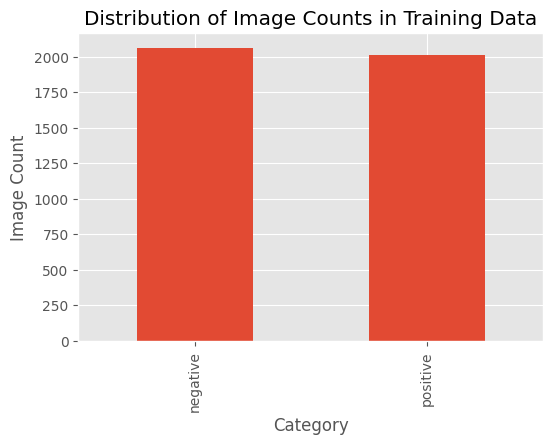

In [10]:
plt.figure(figsize=(6,4))
trn_df['labels'].value_counts().plot(kind='bar')
plt.title('Distribution of Image Counts in Training Data')
plt.xlabel('Category')
plt.ylabel('Image Count')
plt.show()

Negative images slightly outnumber the positive ones, but are close enough to continue without additional data wrangling

<a name='tst_dist'></a>
### 4.2 <span style='color:blue'>|</span> Look at Testing Images' Distribution

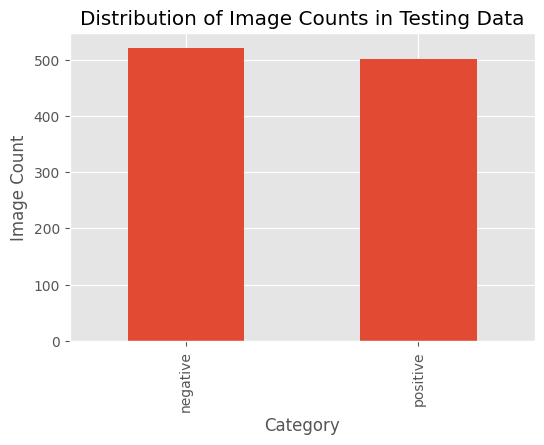

In [11]:
plt.figure(figsize=(6,4))
tst_df['labels'].value_counts().plot(kind='bar')
plt.title('Distribution of Image Counts in Testing Data')
plt.xlabel('Category')
plt.ylabel('Image Count')
plt.show()

Distribution mirrors what the *training data* shows, but with less frequency.

<a name='shape'></a>
### 4.3 <span style='color:blue'>|</span> Examine Shape of Training and Testing DataFrames

In [12]:
print('Training Shape: \n', trn_df.shape)
print('Testing Shape:  \n', tst_df.shape)

Training Shape: 
 (4076, 2)
Testing Shape:  
 (1024, 2)


**NOTE:**&nbsp;&nbsp;Since the dataframes are built from the contents of the image directories, there should be no missing values or duplicates.

<a name='wrangling'></a>
## 4.0 <span style='color:blue'>|</span> Data Wrangling

-------------------------------------
<a name='cr_val'></a>
### 4.1 <span style='color:blue'>|</span> Create a Validation Subset from Training Data
I will use `flow_from_dataframe()` to create datasets for model training; therefore, no reason to create a new directory structure for validation data

In [13]:
val_df, trn_df = train_test_split(trn_df, train_size=0.2, random_state=42,
                                  stratify=trn_df['labels'])
print(val_df.sample(10).to_markdown())
print(f'Validation Shape: {val_df.shape}')

|      | paths                                                                                            | labels   |
|-----:|:-------------------------------------------------------------------------------------------------|:---------|
| 2341 | /home/wiley/regis/dataScience/kaggleProject/images/data/training/positive/Cancer (404).jpg       | positive |
| 1615 | /home/wiley/regis/dataScience/kaggleProject/images/data/training/positive/Cancer (830).jpg       | positive |
| 3949 | /home/wiley/regis/dataScience/kaggleProject/images/data/training/negative/Not Cancer  (595).jpg  | negative |
| 2158 | /home/wiley/regis/dataScience/kaggleProject/images/data/training/positive/Cancer (1965).jpg      | positive |
|   51 | /home/wiley/regis/dataScience/kaggleProject/images/data/training/positive/Cancer (1479).jpg      | positive |
| 1967 | /home/wiley/regis/dataScience/kaggleProject/images/data/training/negative/Not Cancer  (1274).jpg | negative |
| 3644 | /home/wiley/regis/dataScience/kagglePro

<a name='proc_imgs'></a>
### 4.2 <span style='color:blue'>|</span> Process Images from DataFrames
Image augmentation will be used on the training and validation datasets.  The test images will just be normalized. 

In [14]:
# Apply image augmentation
gen = ImageDataGenerator(rescale=1./255,
                         brightness_range=(0.5, 1.5),
                         rotation_range=20,
                         width_shift_range=0.2,
                         height_shift_range=0.2,
                         shear_range=0.2,
                         zoom_range=0.2)

# The test dataset should not be augmented
# just rescaled
tst_gen = ImageDataGenerator(rescale=1./255)

# Create training datagen set
trn_gen = gen.flow_from_dataframe(trn_df, x_col='paths', y_col='labels',
                                  batch_size=batch_size, target_size=img_size,
                                  shuffle=True)

# Create validation datagen set
val_gen = gen.flow_from_dataframe(val_df, x_col='paths', y_col='labels',
                                  batch_size=batch_size, target_size=img_size,
                                  shuffle=True)

# Create test datagen set
tst_gen = tst_gen.flow_from_dataframe(tst_df, x_col='paths', y_col='labels',
                                      batch_size=16, target_size=img_size,
                                      shuffle=False)

Found 3261 validated image filenames belonging to 2 classes.
Found 815 validated image filenames belonging to 2 classes.
Found 1024 validated image filenames belonging to 2 classes.


<a name='exam_imgs'></a>
### 4.3 <span style='color:blue'>|</span> Examine a few Augmented Images and their Labels
The images displayed have been augmented in the previous step

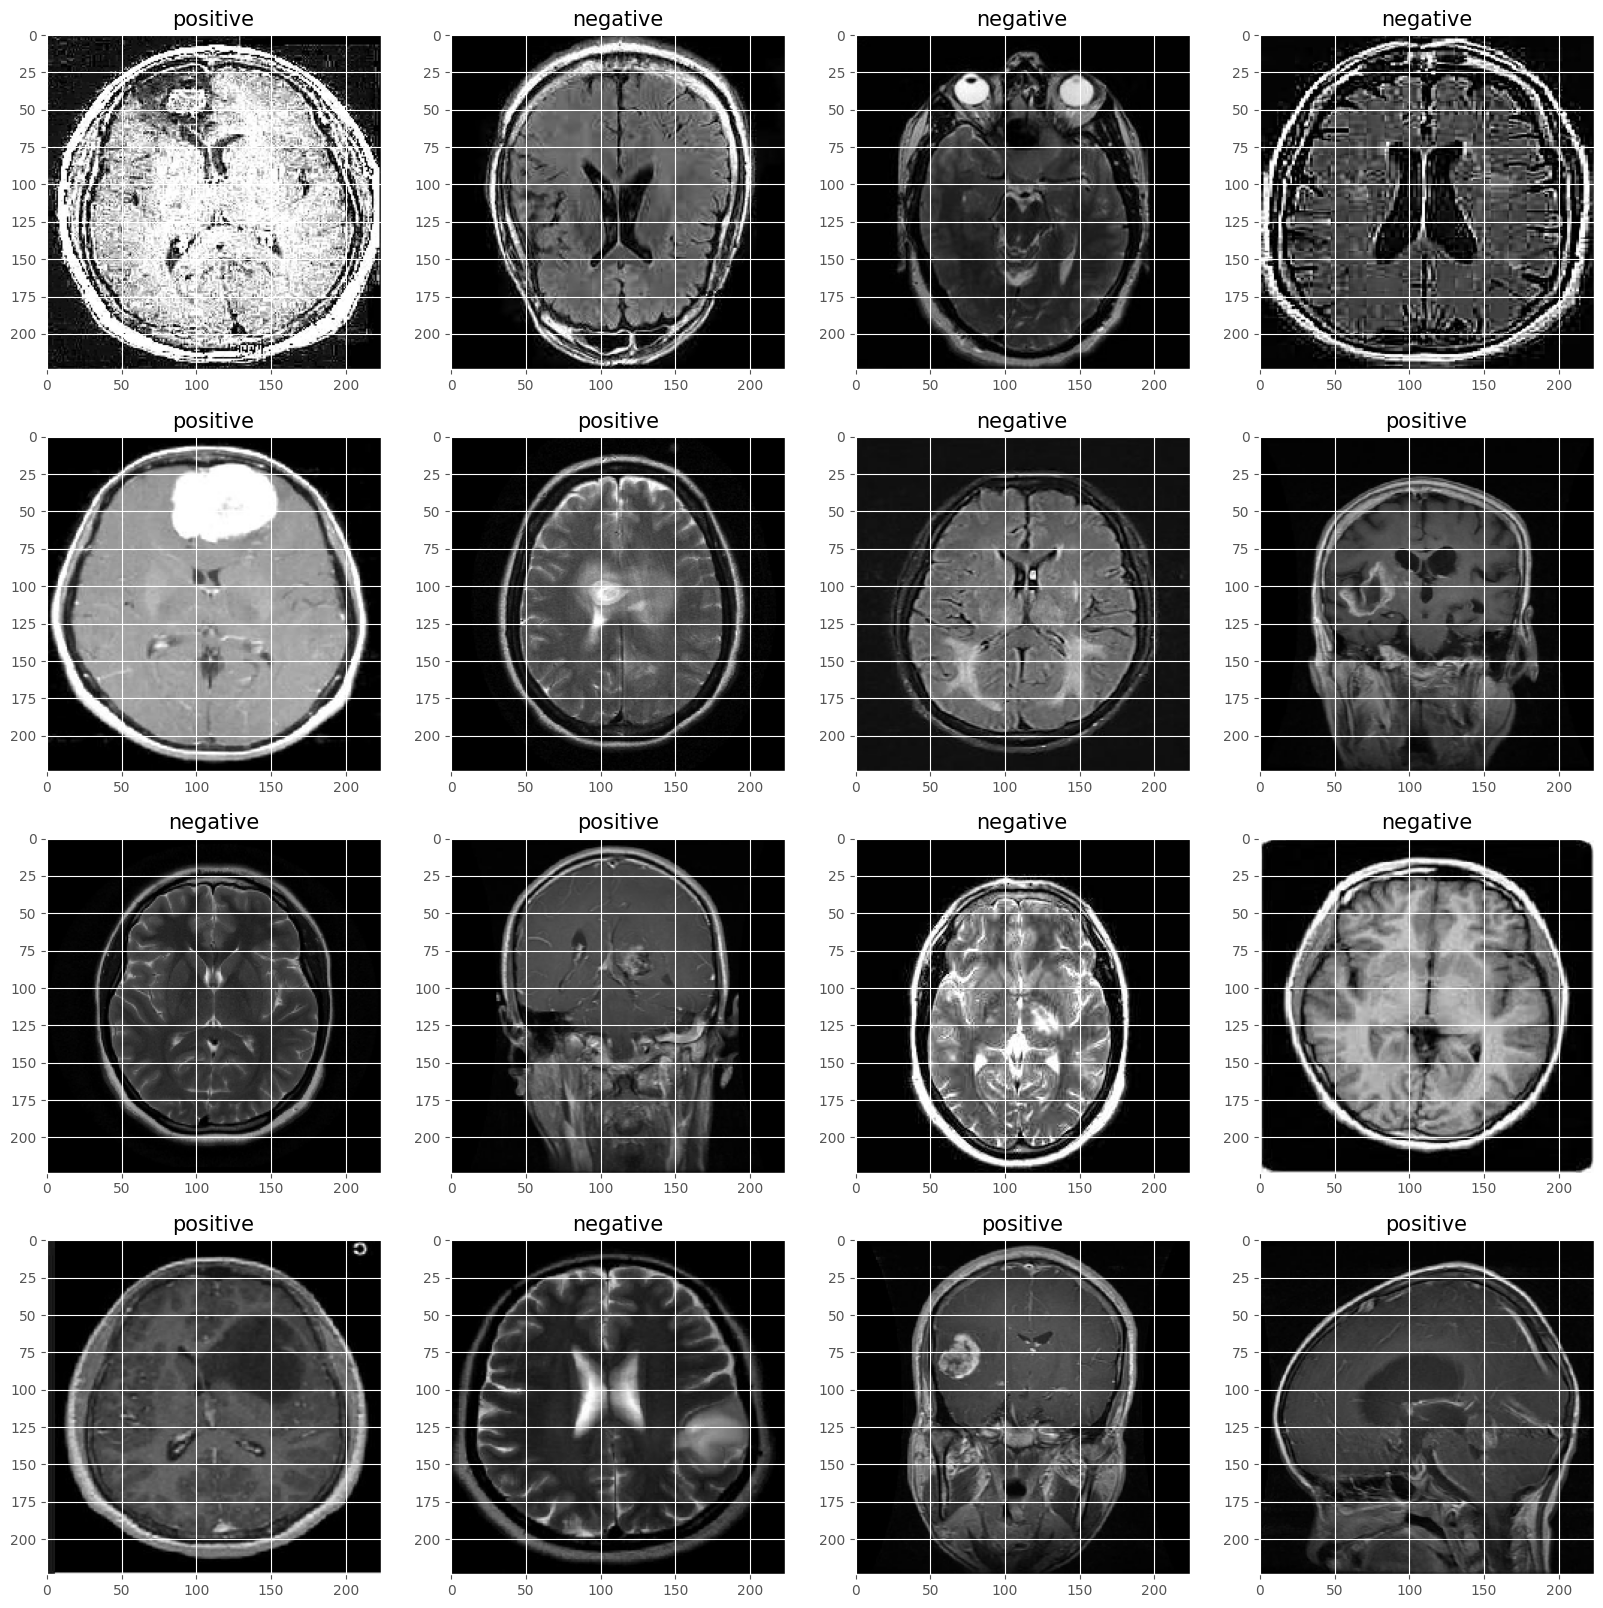

In [15]:
dict = trn_gen.class_indices
classes = list(dict.keys())
images, labels = next(tst_gen)

plt.figure(figsize=(20,20))
for i, (image, label) in enumerate(zip(images, labels)):
    plt.subplot(4,4,i+1)
    plt.imshow(image)
    class_name = classes[np.argmax(label)]
    plt.title(class_name, color='k', fontsize=15)

plt.show()

<a name='configure'></a>
## 5.0 <span style='color:blue'>|</span> Configure Training Values

-----------------------------------------------
<a name='basic_values'></a>
### 5.1 <span style='color:blue'>|</span> Basic Values

In [16]:
# Number of training epochs
epochs = 50

# Steps per epoch
steps_per_ep = trn_gen.samples // batch_size

# Validation steps
val_steps = tst_gen.samples // batch_size

print(f'Image shape:      {img_shape}')
print(f'Epochs:           {epochs}')
print(f'Batch size:       {batch_size}')
print(f'Steps per epoch:  {steps_per_ep}')
print(f'Validation steps: {val_steps}')

Image shape:      (224, 224, 3)
Epochs:           50
Batch size:       64
Steps per epoch:  50
Validation steps: 16


<a name='callbacks'></a>
### 5.2 <span style='color:blue'>|</span> Define Callbacks
With these *callbacks* the model's training will stop if the validation loss stops decreasing (`EarlyStopping()`), and the learning rate will be reduced until the validation loss plateaus (`ReduceLROnPlateau()`)

In [17]:
# Define early_stop callback
early_stop = EarlyStopping(monitor='loss', min_delta=0.000000001, patience=5,
                           baseline=None, restore_best_weights=True, start_from_epoch=0)

# Define reduce LR on Plateau callback
reduceLRO = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=8, mode='auto',
                              min_delta=0.0001, cooldown=0, min_lr=0)

<a name='baseline_model'></a>
## 6.0 <span style='color:blue'>|</span> Baseline Model
### Define Model's Architecture

--------------------------------------------
<a name='architecture'></a>
### 6.1 <span style='color:blue'>|</span> Define Model's Architecture
The CNN model is being defined by using `models.Sequential()` method.  It consists of four convolution layers flattened into two fully connected layers with dropout.  The output layer will use the *softmax* activation function instead of *relu*

In [18]:
backend.clear_session()

model_cnn = models.Sequential([
    # Conv layer #1
    Conv2D(32, (4,4), activation='relu', input_shape=img_shape),
    MaxPooling2D(pool_size=(3,3)),

    # Conv layer #2
    Conv2D(64, (4,4), activation='relu'),
    MaxPooling2D(pool_size=(3,3)),

    # Conv layer #3
    Conv2D(128, (4,4), activation='relu'),
    MaxPooling2D(pool_size=(4,4)),

    # Conv layer #4
    Conv2D(128, (4,4), activation='relu'),
    Flatten(),

    # Fully connect layers
    Dense(512, activation='relu'),
    Dropout(0.5, seed=42),
    Dense(num_classes, activation='softmax')
])

model_cnn.summary()

I0000 00:00:1741135573.924115  892713 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9645 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070, pci bus id: 0000:09:00.0, compute capability: 8.9


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 221, 221, 32)   │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 73, 73, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 70, 70, 64)     │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 20, 20, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 5, 5, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 2, 2, 128)      │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 691,554 (2.64 MB)

 Trainable params: 691,554 (2.64 MB)

 Non-trainable params: 0 (0.00 B)

<a name='layered_view'></a>
### 6.2 <span style='color:blue'>|</span> Visualize Layers

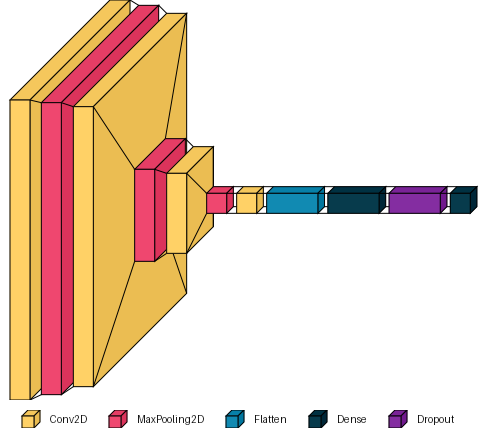

In [19]:
layered_view(model_cnn, legend=True, max_xy=300)

<a name='compile'></a>
### 6.3 <span style='color:blue'>|</span> Compile and Train Model
The `Adam()` optimizer was selected for this model, since it is well suited to classification problems.  The loss function `categorical_crossentropy()` was also selected for the same reason.

In [20]:
# Configure Adam optimizer
opt = optimizers.Adam(learning_rate=0.001, beta_1=0.869, beta_2=0.995)

# Compile base model
model_cnn.compile(optimizer=opt, loss='categorical_crossentropy',
                  metrics=['accuracy',
                           tf.keras.metrics.Precision(name='precision'),
                           tf.keras.metrics.Recall(name='recall'),
                           tf.keras.metrics.AUC(curve='PR', name='auc')])

# Fit data to model and record training history
hist_cnn = model_cnn.fit(trn_gen, batch_size=batch_size, steps_per_epoch=steps_per_ep, 
                         epochs=epochs, validation_data=val_gen,
                         validation_steps=val_steps,
                         callbacks=[early_stop, reduceLRO])

Epoch 1/50


I0000 00:00:1741135578.116676  892841 service.cc:148] XLA service 0x7fae80011370 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1741135578.116713  892841 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4070, Compute Capability 8.9
I0000 00:00:1741135578.445644  892841 cuda_dnn.cc:529] Loaded cuDNN version 90300


 2/50 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.5664 - auc: 0.5364 - loss: 0.7106 - precision: 0.5664 - recall: 0.5664

I0000 00:00:1741135583.163987  892841 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


50/50 ━━━━━━━━━━━━━━━━━━━━ 54s 946ms/step - accuracy: 0.5227 - auc: 0.5180 - loss: 0.6981 - precision: 0.5227 - recall: 0.5227 - val_accuracy: 0.5264 - val_auc: 0.5527 - val_loss: 0.6900 - val_precision: 0.5264 - val_recall: 0.5264 - learning_rate: 0.0010
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 151ms/step - accuracy: 0.4531 - auc: 0.5316 - loss: 0.6943 - precision: 0.4531 - recall: 0.4531 - val_accuracy: 0.5202 - val_auc: 0.5394 - val_loss: 0.6907 - val_precision: 0.5202 - val_recall: 0.5202 - learning_rate: 0.0010
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 36s 728ms/step - accuracy: 0.5743 - auc: 0.5815 - loss: 0.6839 - precision: 0.5743 - recall: 0.5743 - val_accuracy: 0.5951 - val_auc: 0.6283 - val_loss: 0.6639 - val_precision: 0.5951 - val_recall: 0.5951 - learning_rate: 0.0010
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 156ms/step - accuracy: 0.6719 - auc: 0.6823 - loss: 0.6396 - precision: 0.6719 - recall: 0.6719 - val_accuracy: 0.6098 - val_auc: 0.6383 - val_loss: 0.6741 - val_precisio

<a name='evaluate'></a>
## 7.0 <span style='color:blue'>|</span> Evaluate Performance

------------------------------------------------------------
<a name='history'></a>
### 7.1 <span style='color:blue'>|</span> Plot Training and Validation Metrics
If the training and validation metrics diverge significantly from each other, that can be an indication of overfitting.

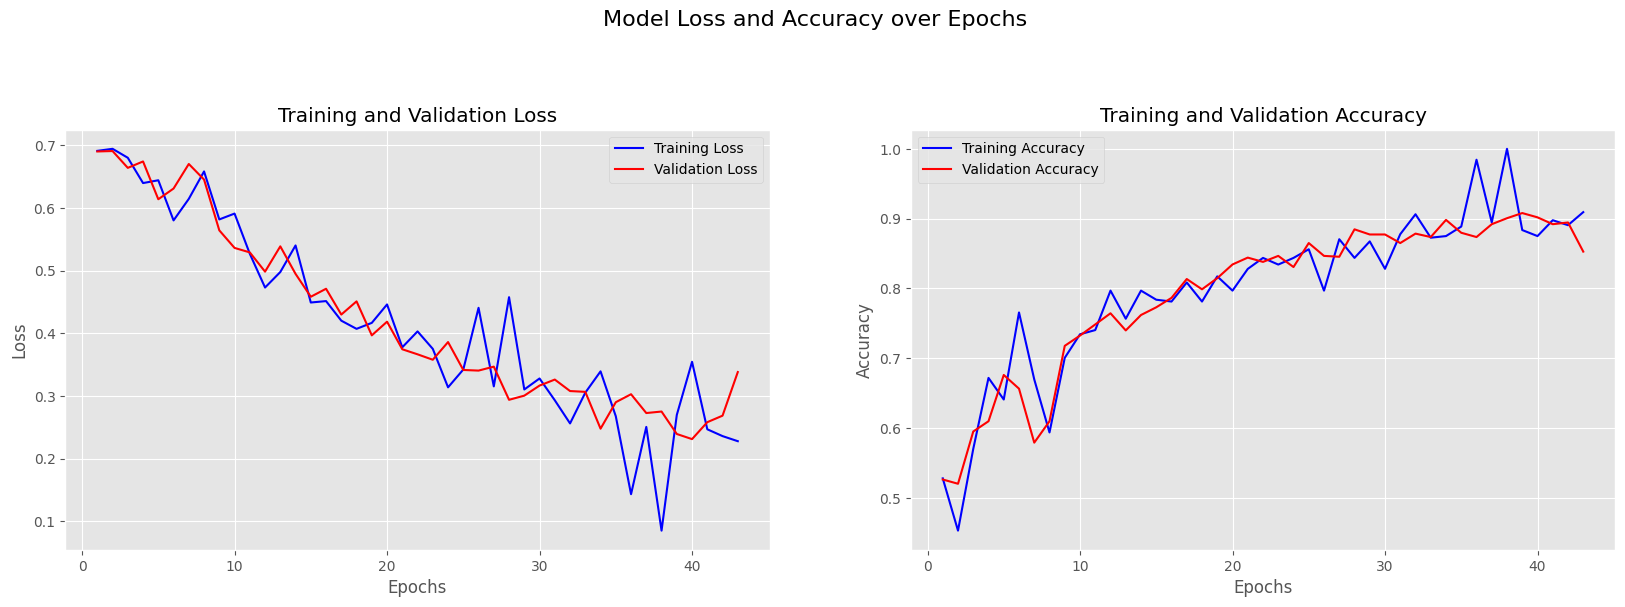

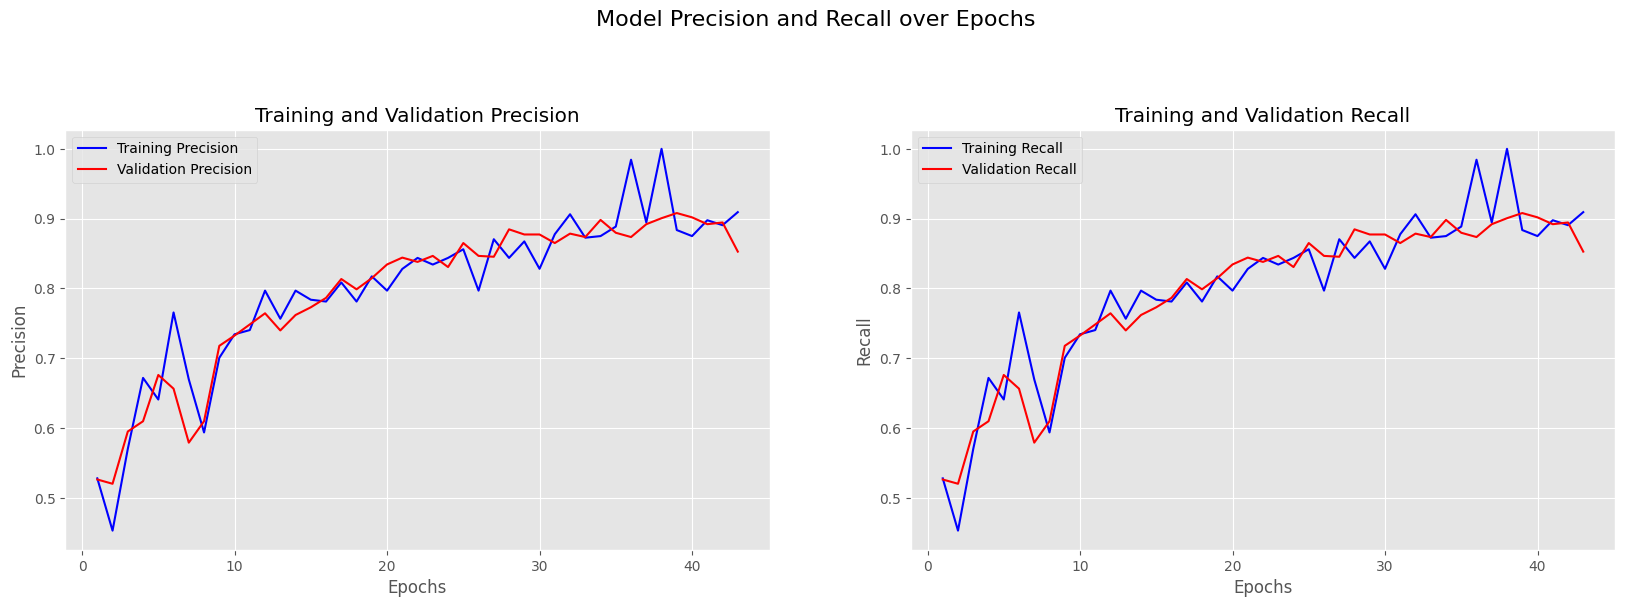

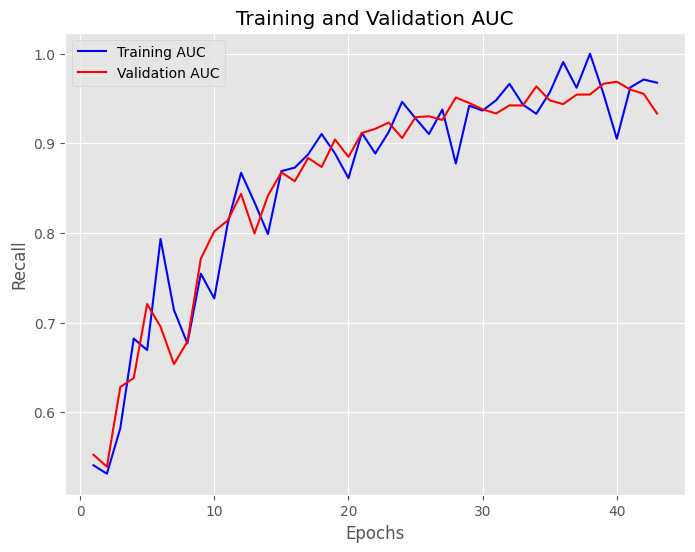

In [21]:
plot_history(hist_cnn)

<a name='score'></a>
### 7.2 <span style='color:blue'>|</span> Score Model
To evaluate the model's performance the following matrices will be evaluated against the test dataset:
- Model Loss&nbsp;&mdash;&nbsp;gives a nuanced view of model optimization
- Model Accuracy&nbsp;&mdash;&nbsp;provides the proportion of all classifications that were correct
- Precision&nbsp;&mdash;&nbsp;is the proportion of the model's positive classifications that are actually positive
- Recall&nbsp;&mdash;&nbsp;proportion of correct positive classifications
- Area Under Curve (AUC)&nbsp;&mdash;&nbsp;represents the probability that the model, if given a randomly chosen positive and negative example, will rank the positive higher than the negative
- F1 Score&nbsp;&mdash;&nbsp;describes the harmonic mean of the precision and recall of the model

In [22]:
score_model(model_cnn, tst_gen)

64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.9015 - auc: 0.9547 - loss: 0.3366 - precision: 0.9015 - recall: 0.9015
------------------------------
Loss:      0.2623
Accuracy:  0.9141
Precision: 0.9141
Recall:    0.9656
AUC:       0.9141
F1 Score:  0.9391
------------------------------


<a name='plot_cm'></a>
### 7.3 <span style='color:blue'>|</span> Plot Confusion Matrix
A confusion matrix provides a visual representation of a model's performance when it comes to comparing true positives, false negatives, true negatives, and false positives.

64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step


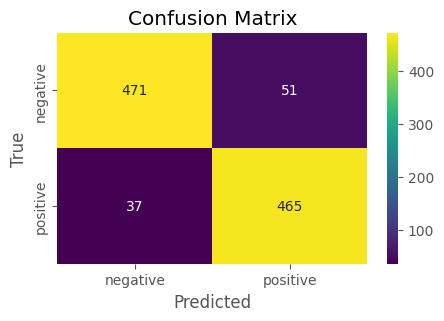

In [23]:
plot_cm(model_cnn, tst_gen)

<a name=tpr_tnr></a>
### 7.4 <span style='color:blue'>|</span> Compute TPR and TNR
The True Positive Rate (TPR) and True Negative Rate (TNR) are good indicators of how well the model is predicting positives (1s) and negatives (0s).  

In [24]:
compute_tpr(model_cnn, tst_gen)

64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step
------------------------------
True Positive Rate (TPR): 0.9263
True Negative Rate (TNR): 0.9023
------------------------------


<a name='discussion'></a>
## 8.0 <span style='color:blue'>|</span> Discussion and Conclusions

---------------------------------------------------


<a name='general'></a>
### 8.1 <span style='color:blue'>|</span> General Performance
The model is generalizing the test data well.  The plots indicated the model is training well and overfitting is minimal.  Training and Validation metrics closely follow each other during the training process and I do not see any items that are concerning.  F1, True Positive, and True Negative scores are above 0.90 which indicates it is accurately predicting positive and negative labels with 90% accuracy. 

<a name='further'></a>
### 8.2 <span style='color:blue'>|</span> Further Work
While the model is generalizing the test data with acceptable results, it can do better.  I will conduct further research on CNN model tuning and keep experimenting until results are consistently in the high 90s.